### 0) Import Packages

In [635]:
import time
import copy

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cuda for inference


### 1) Hyperparameters

In [636]:
#Train
BATCH_SIZE = 128
NUM_EPOCHS = 10

#Optimizer
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.005
MOMENTUM = 0.9

#Model
NUM_INPUTS = 1*28*28 # grayscale (1-channel) 28*28 picture
NUM_CLASSES = 10 # digits 0 to 9


### 2) Load MNIST Dataset

In [637]:
transform=transforms.Compose([
        transforms.ToTensor(), # Use tensors
        transforms.Lambda(torch.flatten) # flatten the images
        ])

train_data = datasets.MNIST( 
    root="dataset",
    train=True,
    download=True,
    transform= transform
)

test_data = datasets.MNIST(
    root="dataset",
    train=False,
    download=True,
    transform= transform
)

train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

CLASSES = train_data.classes

### 3) Make Model

In [638]:
class MNISTNet(nn.Module):

    def __init__(self,num_inputs=NUM_INPUTS,num_classes=10):
        super(MNISTNet, self).__init__()

        self.fc1 =  nn.Sequential(
            # num_input(784) -> 200
            nn.Linear(in_features=num_inputs, out_features=200, bias=True),#Applies a linear transformation to the incoming data: y=xA^T+b
            nn.ReLU(), #Applies the rectified linear unit function element-wise
        )

        self.fc2 =  nn.Sequential(
            nn.Linear(in_features=200, out_features=50, bias=True),# 200 -> 50
            nn.ReLU(),
        )

        self.fc3 =  nn.Sequential(
            nn.Linear(in_features=50, out_features=num_classes, bias=True),# 50 -> 10
        )

        self.out =  nn.Sequential(
            nn.Softmax(dim=1), # a Tensor of the same dimension and shape as the input with values in the range [0, 1]
        )

    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x) # dont use softamx if using cross entorpy loss function of pytorch 
        return x

In [639]:
model = MNISTNet(num_inputs=NUM_INPUTS, num_classes=NUM_CLASSES).to(DEVICE)

In [640]:
def compute_accuracy (model, data_loader, device):
    model = model.to(device)
    model = model.eval() # put the model to evaultion mode
    
    num_correct_prediction = 0
    num_total_labels = 0
    
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            probabilities = model(inputs.to(DEVICE))
            predicted_class = torch.argmax(probabilities, dim=1) # Class predicted by model
            
            num_total_labels += labels.size()[0]
            num_correct_prediction += (predicted_class == labels).sum()

    return num_correct_prediction/num_total_labels * 100

### 4) Test w/o Training

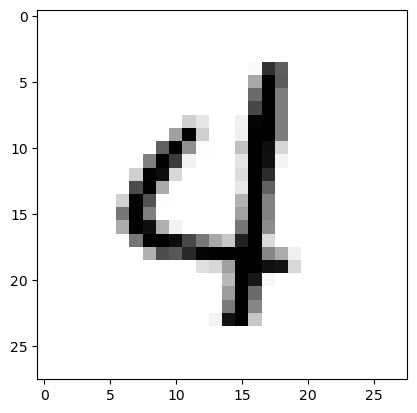

Predicted Num : 9
Actual Num : 4

Total Accuracy on test data : 9.630%


In [641]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

img  = np.reshape(images[4],(28,28))
plt.imshow(img, cmap='Greys')
plt.show()

model = model.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = model(images.to(DEVICE))
    predicted_class = torch.argmax(probabilities,dim=1)

print("Predicted Num : {:d}".format(predicted_class[4]))
print("Actual Num : {:d}".format(labels[4]))
print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(model,test_loader,DEVICE)))

### 5) Train Model

In [642]:
def train_model (model, data_loader, learning_rate, num_epochs,weight_decay,momentum,device):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay,momentum=momentum)
    
    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        
        print("EPOCH : {0}/{1}".format(epoch+1,num_epochs))
        print("-"*30)
        
        # train first
        model.train()
        for batch_index, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)   
             
            probabilities = model(inputs)
            
            optimizer.zero_grad()
            # Using NLL Loss instead of cross entorpy becuase it implements softmax, and our model uses softmax as the output layer
            # Thus to avoid doble softmax I am using NLL loss
            loss = nn.functional.nll_loss(torch.log(probabilities),labels)
                
            loss.backward()
            optimizer.step()
            
            if (batch_index % 50 == 0) :
                print("BATCH : {:3d}/{:3d} | LOSS : {:.3f} ".format(batch_index,len(data_loader),loss))
        
        # evalute
        model.eval()
        with torch.set_grad_enabled(False):
            accuracy = compute_accuracy(model,data_loader,DEVICE)
            print("\nTotal Accuracy On Training Data : {:.3f}%".format(accuracy))
        
        # Save best weights
        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            best_weights = copy.deepcopy(model.state_dict())
        
        print("Elapsed Time : {:.0f} min {:.0f} sec\n".format((time.time() - start_time)/60 , (time.time() - start_time)%60)) 
    
    print("\nTotal Time : {:.0f} min {:.0f} sec".format((time.time() - start_time)/60 , (time.time() - start_time)%60))
    
    
    model.load_state_dict(best_weights)
    return model

In [643]:
model = train_model(model,train_loader,LEARNING_RATE,NUM_EPOCHS,WEIGHT_DECAY,MOMENTUM,DEVICE)

EPOCH : 1/10
------------------------------
BATCH :   0/469 | LOSS : 2.310 
BATCH :  50/469 | LOSS : 2.151 
BATCH : 100/469 | LOSS : 1.290 
BATCH : 150/469 | LOSS : 0.704 
BATCH : 200/469 | LOSS : 0.506 
BATCH : 250/469 | LOSS : 0.436 
BATCH : 300/469 | LOSS : 0.342 
BATCH : 350/469 | LOSS : 0.314 
BATCH : 400/469 | LOSS : 0.392 
BATCH : 450/469 | LOSS : 0.357 

Total Accuracy On Training Data : 90.542%
Elapsed Time : 0 min 11 sec

EPOCH : 2/10
------------------------------
BATCH :   0/469 | LOSS : 0.396 
BATCH :  50/469 | LOSS : 0.485 
BATCH : 100/469 | LOSS : 0.395 
BATCH : 150/469 | LOSS : 0.469 
BATCH : 200/469 | LOSS : 0.375 
BATCH : 250/469 | LOSS : 0.264 
BATCH : 300/469 | LOSS : 0.313 
BATCH : 350/469 | LOSS : 0.282 
BATCH : 400/469 | LOSS : 0.305 
BATCH : 450/469 | LOSS : 0.345 

Total Accuracy On Training Data : 92.158%
Elapsed Time : 0 min 22 sec

EPOCH : 3/10
------------------------------
BATCH :   0/469 | LOSS : 0.244 
BATCH :  50/469 | LOSS : 0.248 
BATCH : 100/469 | LO

### 4) Test w/ Training

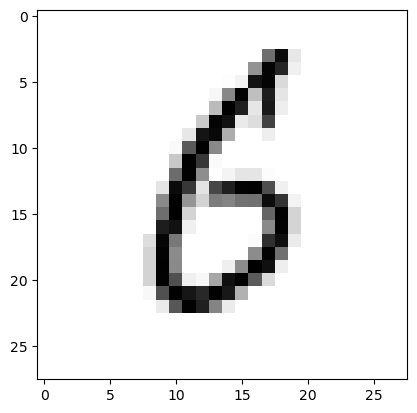

Predicted Num : 6
Actual Num : 6

Total Accuracy on test data : 96.080%


In [644]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

img  = np.reshape(images[4],(28,28))
plt.imshow(img, cmap='Greys')
plt.show()

model = model.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = model(images.to(DEVICE))
    predicted_class = torch.argmax(probabilities,dim=1)

print("Predicted Num : {:d}".format(predicted_class[4]))
print("Actual Num : {:d}".format(labels[4]))
print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(model,test_loader,DEVICE)))